In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [2]:
torch.cuda.set_device(0)

In [3]:
# dls = get_seutao_dls(Meta.df_comb1, np_file, csv_file, bs=64)
dls = get_seutao_dls_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


In [4]:
[x.shape for x in dls.one_batch()[0]]

[torch.Size([64, 60, 2048]), torch.Size([64, 60, 6]), torch.Size([64, 60, 1])]

In [5]:
xb,yb = dls.one_batch()

In [6]:
t = torch.cat(list(xb)+[xb[-1]], axis=-1); t.shape

torch.Size([64, 60, 2056])

## Load

In [7]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [8]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048+6+2
#         d_model = 2048
        n_head = 8
        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_model*2)
        self.transformer = TransformerEncoder(encoder_layers, 2)
        
        self.head = nn.Sequential(nn.Linear(d_model,6))
        
    def forward(self, x):
#         x = x[0]
        x = torch.cat(list(x)+[x[-1]], axis=-1)
#         x = self.linear(x)
        feat = self.transformer(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [9]:
m = SeqHead().cuda()

In [10]:
name = 'seutao_transformer_meta'

In [11]:
learn = get_learner(dls, m)

In [12]:
learn.add_cb(DePadLoss())

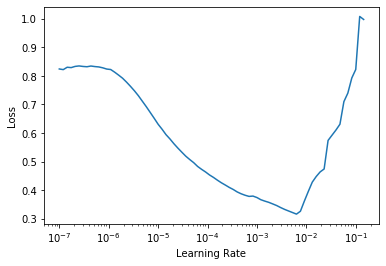

In [34]:
learn.lr_find()

## Train

In [13]:
do_fit(learn, 10, 2e-4)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.073028,0.064217,0.979596,0.961271,00:24
1,0.065215,0.063827,0.978989,0.958135,00:23
2,0.063594,0.059653,0.980205,0.962308,00:24
3,0.064535,0.060192,0.979808,0.962367,00:24
4,0.060475,0.058094,0.980712,0.963428,00:24
5,0.058645,0.058819,0.980124,0.961908,00:23
6,0.057295,0.059273,0.980028,0.961684,00:23
7,0.055955,0.057565,0.980877,0.964324,00:24
8,0.053996,0.057401,0.980860,0.964195,00:24
9,0.053372,0.057344,0.980968,0.964501,00:24


In [ ]:
do_fit(learn, 4, 1e-5)
learn.save(f'runs/{name}-2')

## Submit

In [13]:
submit_predictions(learn.model, f'runs/{name}-1', f'subm/{name}', 'testing seutao features transformer model w/ meta no linear', dfunc=get_seutao_dls_meta)

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:02<00:00, 12.4MB/s]


In [22]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14276986,
 'totalBytes': 27277209,
 'date': '2020-01-23T21:21:13.267Z',
 'description': 'testing seutao features transformer model w/ meta no linear',
 'errorDescription': None,
 'fileName': 'seutao_transformer_meta.csv',
 'publicScore': '1.87853',
 'privateScore': '0.06664',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14276986/14276986.raw'}